In [1]:
from covid_analysis import *

%matplotlib inline
sns.set(style="whitegrid")
FIGSIZE = [12, 8]

# México

In [2]:
estados_analisis = ["Ciudad de México", "Nuevo León", "Jalisco", "Queretaro"]
estados = load_mariorz()
mexico = {}
for ds_name, ds in estados.items():
    mexico[ds_name] = pd.DataFrame({'Mexico': ds.sum(axis=1)})

## Resumen

### Fecha de Actualización:

In [3]:
mexico['confirmados'].index[-1].strftime("%d-%m-%Y")

'09-05-2020'

### Confirmados

In [4]:
sum(mexico['confirmados'].iloc[-1])

33460

### Nuevos Confirmados

In [5]:
sum(mexico['daily_confirmados'].iloc[-1])

1938

### Fallecimientos

In [6]:
sum(mexico['muertos'].iloc[-1])

3353

### Nuevos Fallecimientos

In [7]:
sum(mexico['daily_muertos'].iloc[-1])

193

## Nacional

### México: Confirmados acumulados

,Mexico
Date,
2020-04-26,14677
2020-04-27,15529
2020-04-28,16752
2020-04-29,17799
2020-04-30,19224
2020-05-01,20739
2020-05-02,22088
2020-05-03,23471
2020-05-04,24905


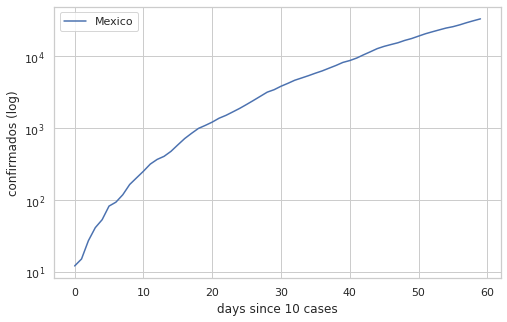

In [8]:
analysis(mexico, ["Mexico"], "confirmados", log=True, smooth=False, since=10)

### México: Confirmados diarios

,Mexico
Date,
2020-04-26,835
2020-04-27,852
2020-04-28,1223
2020-04-29,1047
2020-04-30,1425
2020-05-01,1515
2020-05-02,1349
2020-05-03,1383
2020-05-04,1434


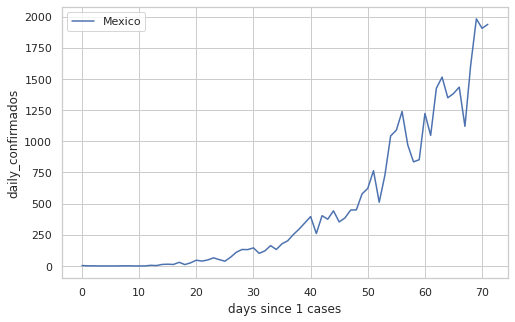

In [9]:
analysis(mexico, ["Mexico"], "daily_confirmados", since=1, smooth=False, log=False)

### México: Fallecimientos acumulados

,Mexico
Date,
2020-04-26,1351
2020-04-27,1434
2020-04-28,1569
2020-04-29,1732
2020-04-30,1859
2020-05-01,1972
2020-05-02,2061
2020-05-03,2154
2020-05-04,2270


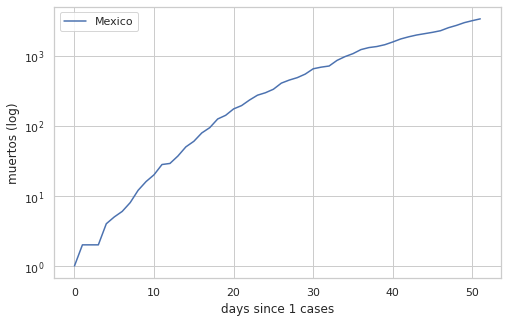

In [10]:
analysis(mexico, ["Mexico"], "muertos", since=1, smooth=False, log=True)

### México: Fallecimientos diarios

,Mexico
Date,
2020-04-26,46
2020-04-27,83
2020-04-28,135
2020-04-29,163
2020-04-30,127
2020-05-01,113
2020-05-02,89
2020-05-03,93
2020-05-04,116


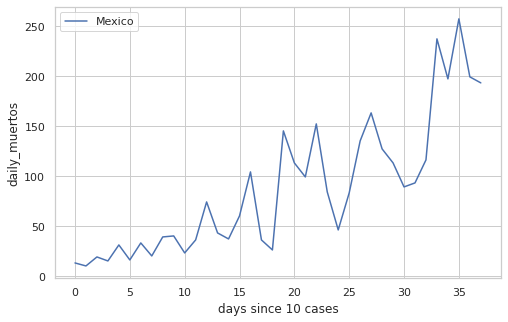

In [11]:
analysis(mexico, ["Mexico"], "daily_muertos", since=10, smooth=False, log=False)

### México: Pruebas reportadas por día, acumuladas

,Mexico
Date,
2020-04-26,67635
2020-04-27,71103
2020-04-28,77005
2020-04-29,81912
2020-04-30,87372
2020-05-01,91188
2020-05-02,93791
2020-05-03,95839
2020-05-04,100041


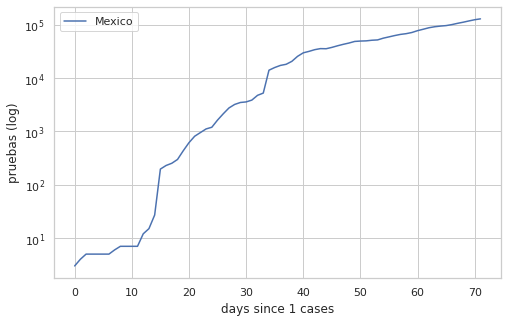

In [40]:
mexico['pruebas'] = mexico['confirmados'].add(mexico['probables']).add(mexico['descartados'])
analysis(mexico, ['Mexico'], 'pruebas', since=1, smooth=False, log=True)

### México: Pruebas reportadas por día

,Mexico
Date,
2020-04-10,2397
2020-04-11,1586
2020-04-12,-178
2020-04-13,2094
2020-04-14,2696
2020-04-15,2611
2020-04-16,2446
2020-04-17,3217
2020-04-18,802


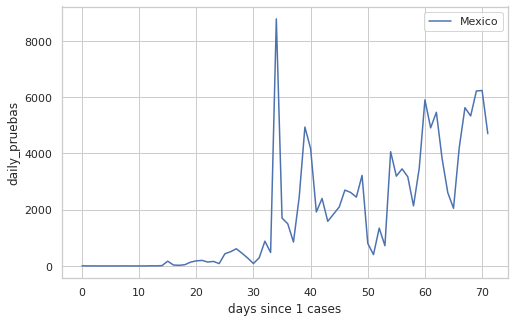

In [13]:
mexico['daily_pruebas'] = mexico['daily_confirmados'].add(mexico['daily_probables']).add(mexico['daily_descartados'])
analysis(mexico, ["Mexico"], "daily_pruebas", since=1, smooth=False, smooth_window=7, log=False, show_last_days=30)

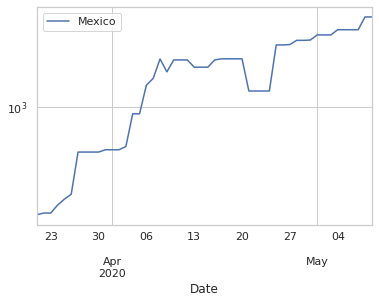

In [14]:
mexico['daily_pruebas'].rolling(window=7).median()[-50:].plot(logy=True)

### México: Proporción de confirmados del total de pruebas reportadas por día

,Mexico
Date,
2020-04-26,0.391101
2020-04-27,0.245675
2020-04-28,0.207218
2020-04-29,0.213369
2020-04-30,0.260989
2020-05-01,0.397013
2020-05-02,0.518248
2020-05-03,0.675293
2020-05-04,0.341266


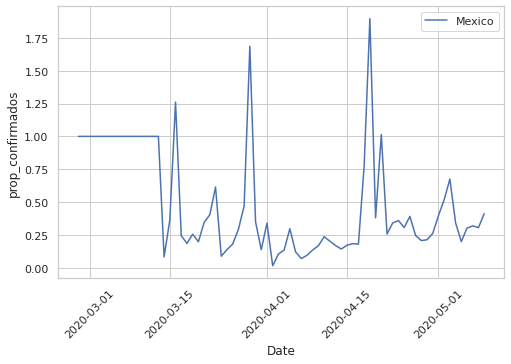

In [15]:
mexico['prop_confirmados'] = mexico['daily_confirmados'] / mexico['daily_pruebas']
analysis(mexico, ['Mexico'], 'prop_confirmados', smooth=False, log=False, since=None)

,Mexico
Date,
2020-04-26,0.217003
2020-04-27,0.218401
2020-04-28,0.217544
2020-04-29,0.217294
2020-04-30,0.220025
2020-05-01,0.227431
2020-05-02,0.235502
2020-05-03,0.244900
2020-05-04,0.248948


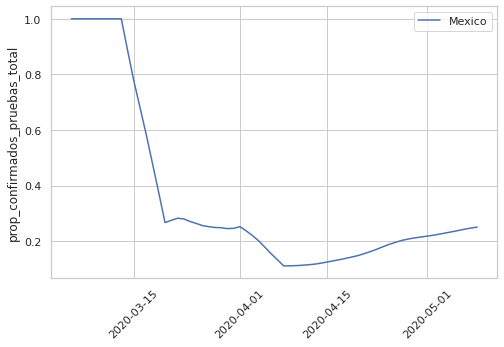

In [16]:
mexico['prop_confirmados_pruebas_total'] = mexico['confirmados'] / mexico['pruebas']
analysis(mexico, ['Mexico'], 'prop_confirmados_pruebas_total', smooth=True, smooth_window=7, log=False, since=None)

### México: proporción de fallecimientos a pruebas, acumulados

,Mexico
Date,
2020-04-26,0.019975
2020-04-27,0.020168
2020-04-28,0.020375
2020-04-29,0.021145
2020-04-30,0.021277
2020-05-01,0.021626
2020-05-02,0.021974
2020-05-03,0.022475
2020-05-04,0.022691


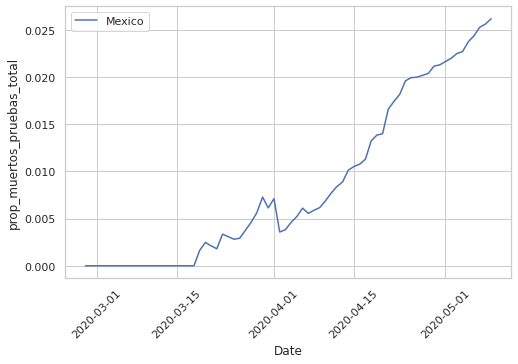

In [17]:
mexico['prop_muertos_pruebas_total'] = mexico['muertos'] / mexico['pruebas']
analysis(mexico, ['Mexico'], 'prop_muertos_pruebas_total', smooth=False, log=False, since=None)

,Mexico
Date,
2020-04-26,0.092049
2020-04-27,0.092343
2020-04-28,0.093660
2020-04-29,0.097309
2020-04-30,0.096702
2020-05-01,0.095087
2020-05-02,0.093309
2020-05-03,0.091773
2020-05-04,0.091146


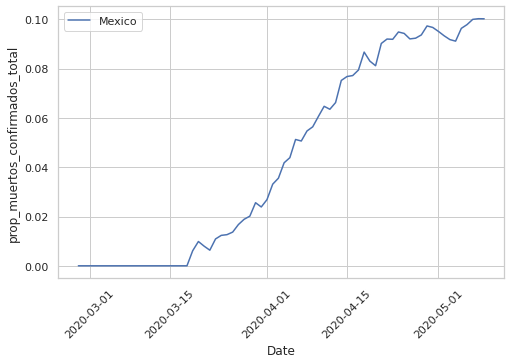

In [18]:
mexico['prop_muertos_confirmados_total'] = mexico['muertos'] / mexico['confirmados']
analysis(mexico, ['Mexico'], 'prop_muertos_confirmados_total', smooth=False, log=False, since=None)

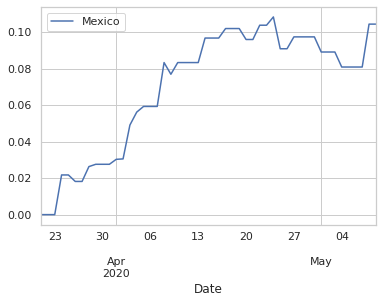

In [38]:
mexico['prop_muertos_confirmados_daily'] = mexico['daily_muertos'] / mexico['daily_confirmados']
mexico['prop_muertos_confirmados_daily'].rolling(window=7).median()[-50:].plot()

## Estados

### Estados: Confirmados acumulados

Estado,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-04-26,4660,287,282,112
2020-04-27,4887,295,303,123
2020-04-28,5261,310,316,125
2020-04-29,5626,324,325,130
2020-04-30,6113,346,348,136
2020-05-01,6491,376,377,150
2020-05-02,7035,415,388,158
2020-05-03,7486,428,419,165
2020-05-04,7916,451,448,177


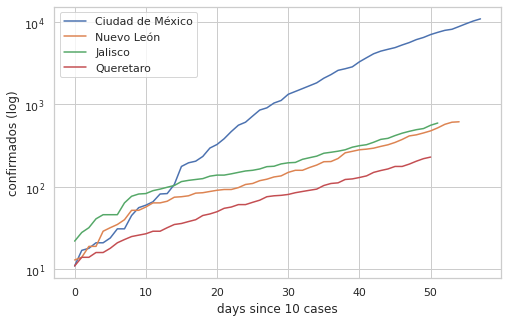

In [19]:
analysis(estados, estados_analisis, "confirmados", since=10, log=True, smooth=False)

### Estados: Confirmados diarios

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-04-26,229,5,11,2
2020-04-27,227,8,21,11
2020-04-28,374,15,13,2
2020-04-29,365,14,9,5
2020-04-30,487,22,23,6
2020-05-01,378,30,29,14
2020-05-02,544,39,11,8
2020-05-03,451,13,31,7
2020-05-04,430,23,29,12


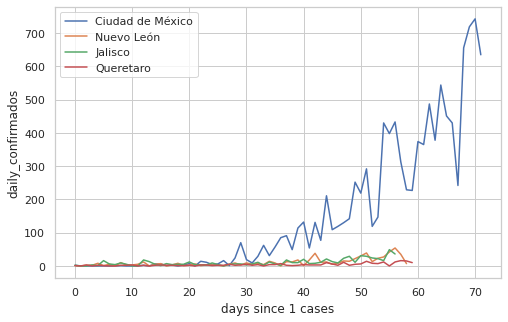

In [20]:
analysis(estados, estados_analisis, "daily_confirmados", since=1, log=False, smooth=False)

### Estados: Fallecimientos diarios 

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-04-26,2,0,2,2
2020-04-27,19,1,0,1
2020-04-28,20,2,0,2
2020-04-29,41,1,0,0
2020-04-30,20,3,3,1
2020-05-01,9,1,2,0
2020-05-02,33,2,2,2
2020-05-03,21,1,1,1
2020-05-04,27,3,1,1


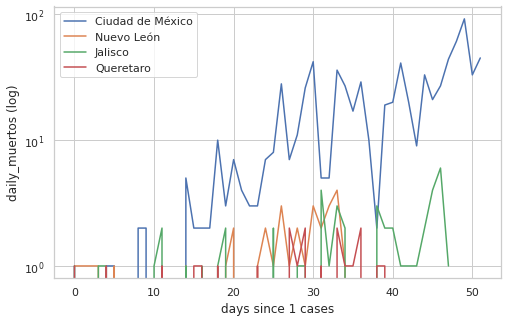

In [21]:
analysis(estados, estados_analisis, "daily_muertos", since=1, log=True, smooth=False)

### Estados: Trayectorias

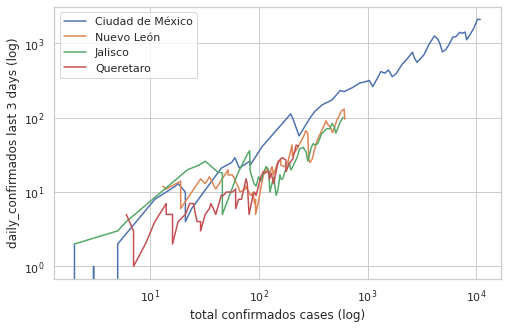

In [22]:
trajectories(estados, estados_analisis, 'confirmados', since=2, window=3)

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-04-26,16208,4897,5011,706
2020-04-27,16952,5052,5143,726
2020-04-28,18587,5272,5335,770
2020-04-29,20104,5503,5542,813
2020-04-30,21795,5734,5729,839
2020-05-01,22684,5917,5915,852
2020-05-02,23340,6044,6018,881
2020-05-03,23823,6143,6062,903
2020-05-04,25095,6358,6241,922


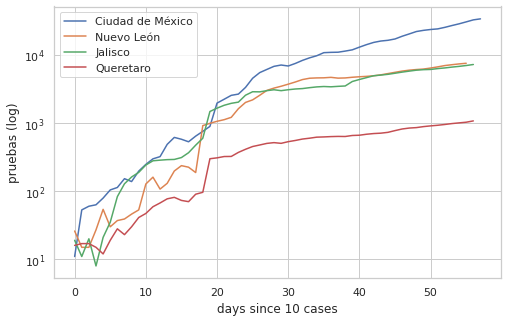

In [23]:
pruebas = {}
for estado in estados['confirmados'].columns:
    pruebas[estado] = estados['confirmados'][estado] + estados['probables'][estado] + estados['descartados'][estado]
estados['pruebas'] = pd.DataFrame(pruebas)
estados['daily_pruebas'] = get_new_per_day(estados['pruebas'])
    
analysis(estados, estados_analisis, "pruebas", since=10, log=True, smooth=False)
#pruebas[-30:].plot(logy=True)

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-04-26,395,96,111,9
2020-04-27,744,155,132,20
2020-04-28,1635,220,192,44
2020-04-29,1517,231,207,43
2020-04-30,1691,231,187,26
2020-05-01,889,183,186,13
2020-05-02,656,127,103,29
2020-05-03,483,99,44,22
2020-05-04,1272,215,179,19


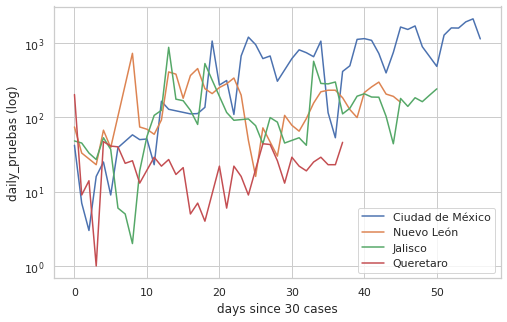

In [24]:
analysis(estados, estados_analisis, "daily_pruebas", since=30, log=True, smooth=False)

# Mundo

In [41]:
analysis_countries = ["Mexico", "US", "Spain", "Italy", "Australia", "Korea, South", "Brazil"]
world = load_johns_hopkins()

## Mundo: Confirmados acumulados

Country/Region,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil
Date,,,,,,,
2020-04-25,13842,938154,205905,195351,6694,10728,59324
2020-04-26,14677,965785,207634,197675,6714,10738,63100
2020-04-27,15529,988197,209465,199414,6721,10752,67446
2020-04-28,16752,1012582,210773,201505,6744,10761,73235
2020-04-29,17799,1039909,212917,203591,6752,10765,79685
2020-04-30,19224,1069424,213435,205463,6766,10774,87187
2020-05-01,20739,1103461,213435,207428,6778,10780,92202
2020-05-02,22088,1132539,216582,209328,6799,10793,97100
2020-05-03,23471,1158040,217466,210717,6822,10801,101826


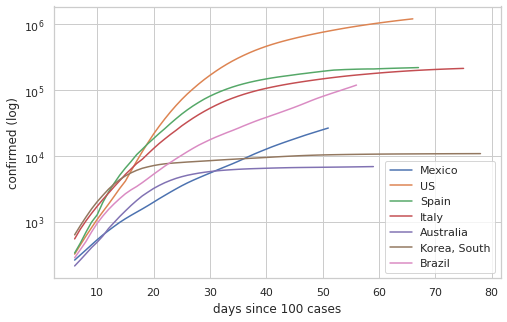

In [42]:
analysis(world, analysis_countries, "confirmed")

## Mundo: Confirmados diarios

,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil
Date,,,,,,,
2020-04-25,970,32796,2915,2357,17,10,5281
2020-04-26,835,27631,1729,2324,20,10,3776
2020-04-27,852,22412,1831,1739,7,14,4346
2020-04-28,1223,24385,1308,2091,23,9,5789
2020-04-29,1047,27327,2144,2086,8,4,6450
2020-04-30,1425,29515,518,1872,14,9,7502
2020-05-01,1515,34037,0,1965,12,6,5015
2020-05-02,1349,29078,3147,1900,21,13,4898
2020-05-03,1383,25501,884,1389,23,8,4726


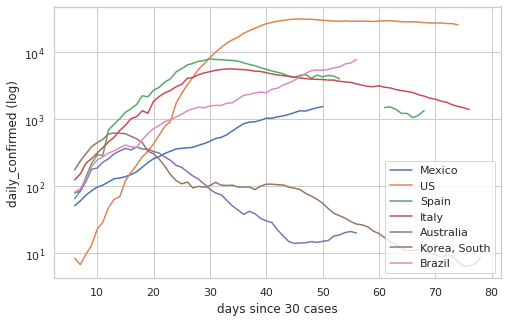

In [43]:
analysis(world, analysis_countries, "daily_confirmed", since=30)

## Mundo: Fallecimientos acumulados

Country/Region,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil
Date,,,,,,,
2020-04-25,1305,53755,22902,26384,80,242,4057
2020-04-26,1351,54881,23190,26644,83,243,4286
2020-04-27,1434,56219,23521,26977,83,244,4603
2020-04-28,1569,58355,23822,27359,89,246,5083
2020-04-29,1732,60967,24275,27682,91,247,5513
2020-04-30,1859,62996,24543,27967,93,248,6006
2020-05-01,1972,64943,24543,28236,93,250,6412
2020-05-02,2061,66369,25100,28710,94,250,6761
2020-05-03,2154,67682,25264,28884,95,252,7051


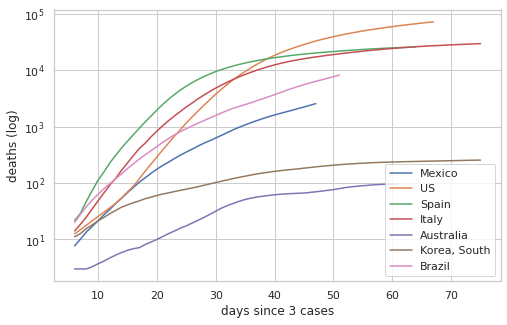

In [44]:
analysis(world, analysis_countries, "deaths", since=3)

## Mundo: Fallecimientos diarios

,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil
Date,,,,,,,
2020-04-25,84,2262,378,415,1,2,353
2020-04-26,46,1126,288,260,3,1,229
2020-04-27,83,1338,331,333,0,1,317
2020-04-28,135,2136,301,382,6,2,480
2020-04-29,163,2612,453,323,2,1,430
2020-04-30,127,2029,268,285,2,1,493
2020-05-01,113,1947,0,269,0,2,406
2020-05-02,89,1426,557,474,1,0,349
2020-05-03,93,1313,164,174,1,2,290


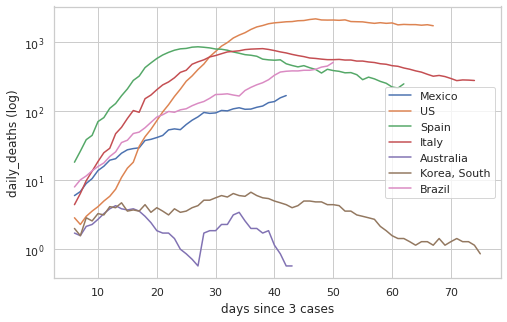

In [45]:
analysis(world, analysis_countries, "daily_deaths", since=3)

## Mundo: Trayectorias de casos confirmados

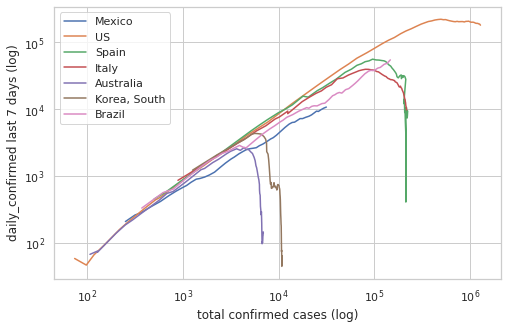

In [46]:
trajectories(world, analysis_countries, 'confirmed', since=50, window=7)

### Revisando

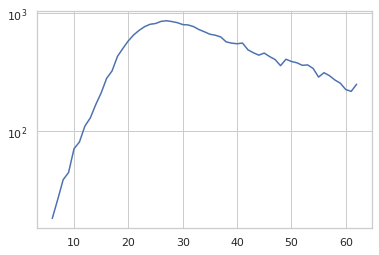

In [47]:
#Aqui hay algunas diferencias con los datos de FT https://www.ft.com/coronavirus-latest 
#  sobre todo en el número de días, ¿es por el rolling average?
d = world['daily_deaths']['Spain']
d = get_values_since_first_geq(d, 3).reset_index(drop=True)
d = d.rolling(window=7).mean()
d.plot(logy=True)